In [18]:

# import regionDetection
from regionDetection import region_detection

ModuleNotFoundError: No module named 'regionDetection'

(256, 256, 3)
found
same channel


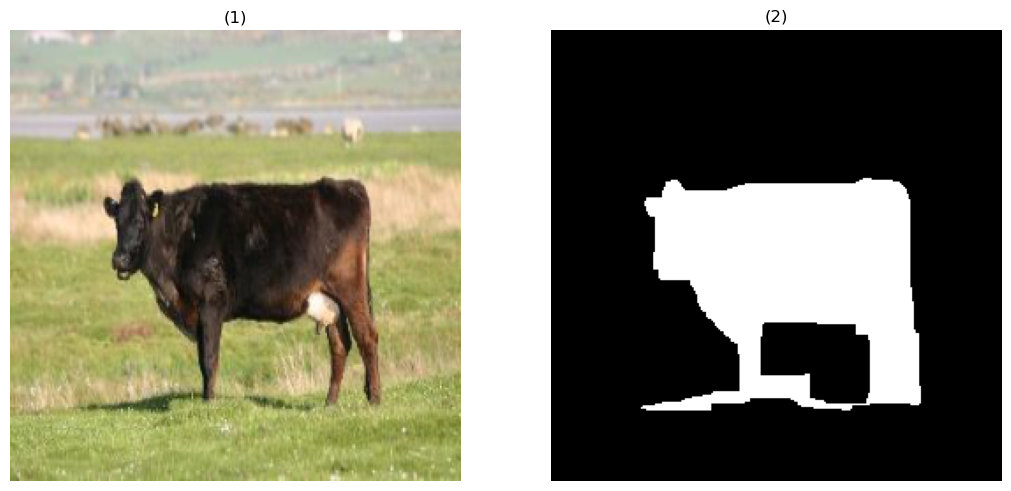

In [3]:
print(cow_resized_orig.shape)
if np.isin(1,binary_mask[:,:,2]):
    print("found")
if binary_mask[:,:,1].all()==binary_mask[:,:,2].all(): 
    print("same channel")
show_images([cow_resized_orig,binary_mask])

In [4]:
def MSD(target_patch, exemplar_patch, M_bar):
    msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
    return msd

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch=None
    min_combined_error= float('inf')
    for current_patch,other_patch in zip(target_patch,exemplar_patches):
        current_error=MSD(current_patch,other_patch,M_bar)+ SMD(current_patch,other_patch,binary_mask,M_bar)
        if current_error < min_combined_error:
            best_patch = other_patch
    return best_patch

def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [5]:
def main(img,binary_mask):
    patch_size = 8
    img_in_patches= [img[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0],patch_size) for j in range(0,img.shape[1],patch_size) ]
    full_binary_mask_patches = [binary_mask[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0],patch_size) for j in range(0,img.shape[1],patch_size) ]
    #if the patch contains a single 1 then it's subset of the target patch so mark it with 1 in the bit map
    # bit_map=[ 1 if np.isin(1,full_binary_mask_patches[i]) else 0 for i in range(len(full_binary_mask_patches))]

    target_indices=[]
    exemplar_indices=[]
    binary_mask_patches= []
    target_patches=[]
    exemplar_patches=[]
    for i, binary_mask_patch in enumerate(full_binary_mask_patches):
        start_row = ( i // img.shape[0] // patch_size) * patch_size
        start_col = ( i % (img.shape[1] // patch_size)) * patch_size
        if np.isin(1,binary_mask_patch):
            # This means that it is a target patch
            target_indices.append((i,start_row,start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            # binary_mask_patches.append(binary_mask[start_row:start_row+patch_size])

        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])


    # M_bar_patches=[np.where((binary_mask_patches[i]==0)|(binary_mask_patches[i]==1), binary_mask_patches[i]^1, binary_mask_patches) for i in range(len(binary_mask_patches))]
    M_bar_patches=[1-binary_mask_patches[i] for i in range(len(binary_mask_patches))]
    #TO-DO: call implemented functions
    new_target_patches=findBestFullPatch(target_patches,exemplar_patches,binary_mask_patches,M_bar_patches)

    new_img= np.copy(img)
    for target_index, start_row, start_col in target_indices:
        new_img[start_row: start_row+patch_size, start_col:start_col+patch_size]=new_target_patches[target_index]
    
    return new_img

    # list of tuples (i,start_row,start_col)
    '''
    for target_index, start_row, start_col in target_indices:
        img[start_row:start_row+patch_size , start_col: start_col+patch_size]=cp_target_patches[target_index]
        start_row = (i // (img.shape[0] // patch_size)) * patch_size
        start_col = (i % (img.shape[1] // patch_size)) * patch_size
    
    '''




In [6]:
grayLevelImg = rgb2gray(cow_resized_orig)
newImg= main(grayLevelImg,binary_mask[:,:,0])
show_images([newImg])

C:\Users\Habiba ElHussieny\AppData\Local\Temp\ipykernel_4540\2647441226.py:2: RuntimeWarning: invalid value encountered in scalar divide
  msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
C:\Users\Habiba ElHussieny\AppData\Local\Temp\ipykernel_4540\2647441226.py:6: RuntimeWarning: invalid value encountered in scalar divide
  target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)


TypeError: 'NoneType' object is not subscriptable